In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from astropy import units as u
from starkit.fitkit.likelihoods import SpectralChi2Likelihood as Chi2Likelihood, SpectralL1Likelihood
from starkit.gridkit import load_grid
from starkit.fitkit.multinest.base import MultiNest, MultiNestResult
from starkit import assemble_model, operations
from starkit.fitkit import priors
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from specutils import read_fits_file,plotlines
import numpy as np
import os,scipy
from scipy import signal
from specutils import Spectrum1D,rvmeasure
import datetime,glob
import gc
from matplotlib.backends.backend_pdf import PdfPages

import sys
import os

In [2]:

def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()


# try:
#     import MySQLdb as mdb
# except:
#     import pymysql as mdb

specdir = '/u/ghezgroup/data/metallicity/nirspec/spectra/'
savedir = '/u/ghezgroup/data/metallicity/nirspec/spectra_fits/masks/'

starname = 'NGC6791_J19205+3748282'
order = str(35)
radv = 0.0
teff = 4028.
logg = 1.5
mh = 0.44
file2 = glob.glob(specdir+starname+'_order'+order+'*.dat')
print file2
snr = float(48.36096037)
    
starspectrumall = read_fits_file.read_nirspec_dat(file2,desired_wavelength_units='micron')
    
waverange = [np.amin(starspectrumall.wavelength.value[:970]), np.amax(starspectrumall.wavelength.value[:970])]
starspectrum35 = read_fits_file.read_nirspec_dat(file2,desired_wavelength_units='Angstrom',
                                                 wave_range=waverange)
starspectrum35.uncertainty = (np.zeros(len(starspectrum35.flux.value))+1.0/np.float(snr))*starspectrum35.flux.unit


#savefile = os.path.join(savedir,starname+'order'+order+'_phoenixr40000_test2_o36.h5')

print 'here 1 in file'

# load the BOSZ grid. Do this only ONCE!! It takes a long time and lots of memory
g = load_grid('/u/rbentley/metallicity/grids/phoenix_t2000_6000_w21500_22220_R40000_o35.h5')#'/u/rbentley/metallicity/spectra_fits/test_bosz_t2500_6000_w20000_24000_R40000.h5')
print 'grid loaded'

['/u/ghezgroup/data/metallicity/nirspec/spectra/NGC6791_J19205+3748282_order35_nod1.dat', '/u/ghezgroup/data/metallicity/nirspec/spectra/NGC6791_J19205+3748282_order35_nod2.dat']
clipping [2.1811267999999999, 2.2103229]
here 1 in file
[starkit.gridkit.base][INFO   ]  Reading index (base.py:266)
[starkit.gridkit.base][INFO   ]  Discovered columns teff, logg, mh, alpha (base.py:269)
[starkit.gridkit.base][INFO   ]  Reading Fluxes (base.py:272)
[starkit.gridkit.base][INFO   ]  Fluxes shape (12800, 5271) (base.py:275)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/astropy/units/format/generic.py:461: UnitsWarning: 'erg/s/angstrom' contains multiple slashes, which is discouraged by the FITS standard
  core.UnitsWarning)
 (generic.py:461)
[starkit.gridkit.base][INFO   ]  Initializing spec grid (base.py:309)
[starkit.gridkit.base][WARNING]  **** NO WAVELENGTH TYPE SET DEFAULTING TO GRID (vacuum) ****

 (base.py:75)
grid loaded


In [4]:
interp1 = Interpolate(starspectrum35)
print 'interpolated'
convolve1 = InstrumentConvolveGrating.from_grid(g,R=24000)
print 'convolved'
rot1 = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
print 'rot broadend'
norm1 = Normalize(starspectrum35,2)
print 'normalized'
# concatenate the spectral grid (which will have the stellar parameters) with other
# model components that you want to fit
model = g | rot1 |DopplerShift(vrad=radv)| convolve1 | interp1 | norm1
print 'model concaten'


interpolated
convolved
rot broadend
normalized
model concaten


In [5]:
'''

w,f = model()

#plt.plot(w,f)
    
model.teff_0 = teff
model.logg_0 = logg
model.mh_0 = mh
w,f = model()
'''
unmasked_median_fits = {"teff_0":3891.,
                        "logg_0":0.104,
                        "mh_0":0.0023,
                        "alpha_0":0.305,
                        "vrot_1":0.928,
                        "vrad_2":140.6,
                        "R_3":24000.}

for a in unmasked_median_fits.keys():
    setattr(model,a,unmasked_median_fits[a])


wref, fref = model()

resampled_apogeew = (signal.resample(wref, len(starspectrum35.wavelength.value)))/(radv/3e5+1.0)
resampled_apogeef = signal.resample(fref, len(starspectrum35.flux.value))

#apogee_res = 
#apogee_mask = []
#apogee_mask_w = []
apogee_ind = np.where(abs(starspectrum35.flux.value - resampled_apogeef)>0.05)

        

[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/starkit/base/operations/spectrograph.py:192: UserWarning: The fit may be poorly conditioned
  warnings.warn(msg)
 (spectrograph.py:192)


In [6]:


apogee_ind_s = sorted(apogee_ind, reverse=True)

starspectrum_fmasked = np.delete(starspectrum35.flux,apogee_ind_s)
starspectrum_wmasked = np.delete(starspectrum35.wavelength,apogee_ind_s)
starspectrum_umasked = np.delete(starspectrum35.uncertainty,apogee_ind_s)
print len(starspectrum_fmasked), len(apogee_ind)

spectrum_masked = Spectrum1D.from_array(dispersion=starspectrum_wmasked, flux=starspectrum_fmasked, uncertainty=starspectrum_umasked) 
                                        #flux_unit=starspectrum35.flux.unit, wavelength_unit=starspectrum35.wavelength.unit)
print spectrum_masked.flux
    
interp1 = Interpolate(spectrum_masked)
print 'interpolated 2'
convolve1 = InstrumentConvolveGrating.from_grid(g,R=24000)
print 'convolved 2'
rot1 = RotationalBroadening.from_grid(g,vrot=np.array([10.0]))
print 'rot broadend 2'
norm1 = Normalize(spectrum_masked,2)
print 'normalized 2'
# concatenate the spectral grid (which will have the stellar parameters) with other
# model components that you want to fit


741 1
[ 1.013565   1.059985   1.064255   1.03773    1.035515   1.05892    1.06102
  1.08322    1.079395   1.09013    1.075935   1.07198    1.077365   1.08456
  1.082125   1.064365   1.071275   1.099905   1.09971    1.09615    1.05902
  1.02991    1.011188   1.004722   1.061675   1.06007    1.03666    0.99182
  1.011685   1.047625   1.069105   1.08958    1.07624    1.09576    1.07792
  1.088955   1.074765   1.059695   1.033925   1.014015   1.0020095
  1.020415   1.04593    1.065925   1.010165   0.935775   1.02051    0.9988815
  1.03347    1.049475   1.0144     0.9593005  1.03401    1.04642    0.980199
  0.8202355  1.035065   1.059645   0.996421   0.940925   0.958847
  1.0008755  1.0246     1.053385   1.07715    1.082205   1.07965    1.034795
  0.991193   0.9912195  1.01171    1.02885    0.996053   0.975087   0.994767
  1.025895   1.045785   1.05456    1.066935   1.04284    1.02872    1.05597
  1.033855   1.02359    1.02957    0.9935385  0.990021   1.00825    1.02126
  1.045475   1.08293

In [7]:
model = g | rot1 |DopplerShift(vrad=radv)| convolve1 | interp1 | norm1
print 'model concaten 2'

#masked_w,masked_f = model()
    
#for i in sorted(apogee_ind, reverse=True):
#    print i
#    np.delete(starspectrum35.wavelength, i)
#    np.delete(starspectrum35.flux, i)
#del starspectrum35.wavelength[i]
# add likelihood parts
like1 = Chi2Likelihood(spectrum_masked)
#like1_l1 = SpectralL1Likelihood(spectrum)



fit_model = model | like1
print 'here 2', len(starspectrum_umasked)
# look at parameters in the model
model
    
'''
plt.plot(w,f)
plt.plot(starspectrum35.wavelength,starspectrum35.flux)
'''



#plt.savefig('testfig1.pdf')
print(fit_model())

model concaten 2
here 2 741
-8270.31775053


In [8]:
teff_prior = priors.UniformPrior(1000,6000)
logg_prior = priors.UniformPrior(0.1,4.0)
mh_prior = priors.UniformPrior(-2.0,1.0)
alpha_prior = priors.UniformPrior(-0.25,0.5)
vrot_prior = priors.UniformPrior(0,350.0)
vrad_prior1 = priors.UniformPrior(-1000,1000)
#R_prior1 = priors.UniformPrior(1500,5000)
R_prior1 = priors.FixedPrior(24000)

# make a MultiNest fitting object with the model and the prior
gc_fitobj = MultiNest(fit_model, [teff_prior, logg_prior, mh_prior, alpha_prior,vrot_prior, vrad_prior1,R_prior1])

In [10]:
# Run the fit using the MultiNest sampler.
# Will take about 5-10 minutes to run for high resolution Phoenix grid
gc_result = gc_fitobj.run()

# after fitting, save the results to an HDF5 file
#gc_result.to_hdf(savefile)
print "here"
# load from the HDF5 file in case the fit was not run
#gc_result = MultiNestResult.from_hdf5(savefile)

[starkit.fitkit.multinest.base][INFO   ]  Starting fit in /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpmq6MF2 with prefix specgrid_multinest (base.py:307)
[starkit.fitkit.multinest.base][INFO   ]  Fit finished - took 305.25 s (base.py:314)
[starkit.fitkit.multinest.base][INFO   ]  Cleaning up - deleting /var/folders/ht/yg1qpdss7450bj58zbkchp9c00011x/T/tmpmq6MF2 (base.py:322)
here


teff_0      3898.589331
logg_0         0.129334
mh_0          -0.007423
alpha_0        0.293693
vrot_1         2.660100
vrad_2       140.577259
R_3        24000.000000
dtype: float64
teff_0      3899.845733
logg_0         0.139944
mh_0          -0.009367
alpha_0        0.292325
vrot_1         2.701754
vrad_2       140.583959
R_3        24000.000000
dtype: float64 end


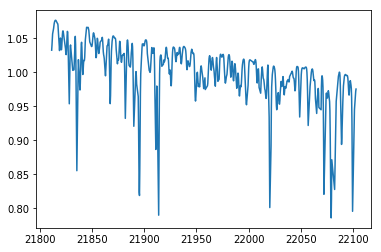

In [11]:
# summary statistics like the mean and median can be accessed as dictionaries
print(gc_result.median)
print(gc_result.mean), "end"

# can also compute 1 sigma intervals (or arbitrary)
gc_result.calculate_sigmas(1)

# can also make corner plots
# be sure to specify parameters if one of them is fixed - if not, corner will crash
#gc_result.plot_triangle(parameters=['teff_0','logg_0','mh_0','alpha_0','vrot_1','vrad_2'])

# set model to median values
for a in gc_result.median.keys():
    setattr(model,a,gc_result.median[a])
    
w,f = model()
plt.plot(w,f)

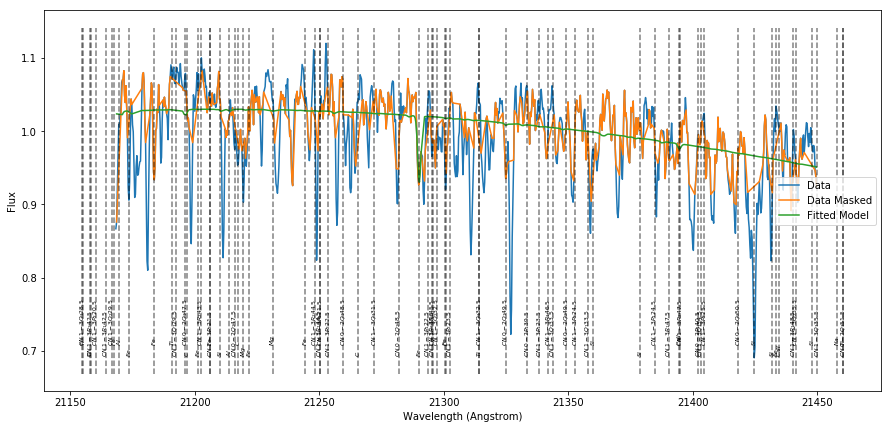

In [34]:
mw,mf = model()

#print "chi squared val ", like1

residual_f = []
residual_w = []

plt.figure(figsize=(15,7))
plt.plot(starspectrum35.wavelength,starspectrum35.flux, label='Data')
plt.plot(spectrum_masked.wavelength,spectrum_masked.flux, label='Data Masked')
plt.plot(mw,mf,label='Fitted Model')
plotlines.oplotlines(angstrom=True,arcturus=True,alpha=0.5,size=6,highlight=['Sc'])
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.legend(loc='center right')
multipage(savedir+starname+'_order'+order+'_masked.pdf')

In [35]:
#resampled_w = (signal.resample(starspectrum35.wavelength.value, len(w)))/(gc_result.median['vrad_2']/3e5+1.0)
#resampled_f = signal.resample(starspectrum35.flux.value, len(f))
'''
resampled_mw = (signal.resample(w, len(starspectrum35.wavelength.value)))/(gc_result.median['vrad_2']/3e5+1.0)
resampled_mf = signal.resample(f, len(starspectrum35.flux.value))
        
residual_f = starspectrum35.flux.value - resampled_mf
print len(resampled_mf)

plt.figure(figsize=(15,7))
plt.plot(starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.flux, label='Data')
plt.plot(w/(gc_result.median['vrad_2']/3e5+1.0),f,label='Fitted Model')
plt.plot(resampled_mw,residual_f,label='Data-Fitted Model Residuals')
plt.axhline(y=0.03, color='r', linestyle='-')
plt.axhline(y=-0.03, color='r', linestyle='-')
plotlines.oplotlines(angstrom=True,arcturus=True,alpha=0.5,size=6,highlight=['Sc'])
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.legend(loc='center right')

model_residuals = f-fref

plt.figure(figsize=(15,7))
plt.plot(starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0),starspectrum35.flux, label='Data')
plt.plot(apogee_mask_w,apogee_mask, label='APOGEE Mask', marker='o')
plt.plot(resampled_apogeew,apogee_res, label='APOGEE Res')
'''
#plt.plot(w/(gc_result.median['vrad_2']/3e5+1.0),f,label='Fitted Model')
#plt.plot(wref/(float(radv)/3e5+1.0),fref,label='Reference Model')
#plt.plot(wref/(float(radv)/3e5+1.0),model_residuals,label='Fitted Model-Ref Model Residuals')

    
#multipage(starname+'_order'+order+'_fixed_logg_mh.pdf')
'''
absresidual = abs(residual_f)

maxres = np.amax(absresidual)

meanres = np.mean(absresidual)

redchi2array = absresidual/starspectrum35.uncertainty.value
print absresidual[0:70]
print starspectrum35.uncertainty.value[0:70]
redchi2array = redchi2array**2
redchi2 = sum(redchi2array)/len(redchi2array)
print redchi2array[0:70]
print len(redchi2array)
print maxres, meanres,redchi2, "max residual and mean residual"
'''
plt.show()
''''
os.chdir('ref_fits')
#outf = open('fitting_params_'+starname+'.dat','a+')
#outf.write(order+'\t'+str(meanres)+'\t'+str(maxres)+'\t'+str(redchi2)+'\n')
#outf.close()


dout = starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0)
mout = w/(gc_result.median['vrad_2']/3e5+1.0)
outf = open('model_plotvals_'+starname+'_order'+order+'.tsv','a+')
for i in range(len(f)):
    outf.write(str(mout[i])+'\t'+str(f[i])+'\t'+str(fref[i])+'\n')
outf.close()

outf = open('data_plotvals_'+starname+'_order'+order+'.tsv','a+')
for i in range(len(starspectrum35.wavelength.value)):
    outf.write(str(dout[i])+'\t'+str(starspectrum35.flux.value[i])+'\n')
outf.close()
os.chdir('..')
g = None
model = None
gc.collect()
'''

"'\nos.chdir('ref_fits')\n#outf = open('fitting_params_'+starname+'.dat','a+')\n#outf.write(order+'\t'+str(meanres)+'\t'+str(maxres)+'\t'+str(redchi2)+'\n')\n#outf.close()\n\n\ndout = starspectrum35.wavelength.value/(gc_result.median['vrad_2']/3e5+1.0)\nmout = w/(gc_result.median['vrad_2']/3e5+1.0)\noutf = open('model_plotvals_'+starname+'_order'+order+'.tsv','a+')\nfor i in range(len(f)):\n    outf.write(str(mout[i])+'\t'+str(f[i])+'\t'+str(fref[i])+'\n')\noutf.close()\n\noutf = open('data_plotvals_'+starname+'_order'+order+'.tsv','a+')\nfor i in range(len(starspectrum35.wavelength.value)):\n    outf.write(str(dout[i])+'\t'+str(starspectrum35.flux.value[i])+'\n')\noutf.close()\nos.chdir('..')\ng = None\nmodel = None\ngc.collect()\n"